In [3]:
# import sys
import numpy as np
import pandas as pd
from imread import imread, imsave
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng

### Prepare images

In [4]:
# directory = "data/ads/duplicate_ads/"
# count = 1

# for filename in os.listdir(directory):
#     filename_without_exten = filename.split('.')[0]
#     foldername = "s" + str(count)
    
#     new_dir = directory + foldername
#     os.mkdir(new_dir)
    
#     count = count + 1

In [5]:
# from shutil import copyfile

# count = 1

# for filename in os.listdir(directory):
#     foldername = "s" + str(count)
    
#     if filename.endswith('.jpg'):
#         source = directory + filename.split('.')[0] + '.jpg'
#         dest = directory + foldername + "/"
        
#         os.rename(source, dest + "1.jpg")
#         copyfile(dest + "1.jpg", dest + "2.jpg")
    
        
#         count = count + 1

### Please give below paths as per the paths in your system

In [6]:
train_folder = "data/ads/duplicate_ads/"
val_folder = 'data/ads/non_duplicated_ads/'
save_path = 'data/pickles'

In [7]:
def loadimgs(path,n = 0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    ads_dict = {}
    #     lang_dict = {}
    curr_y = n
    # we load every ad seperately so we can isolate them later
    for ad in os.listdir(path):
        if ad.startswith("s"):
            print("loading ads: " + ad)
            ads_dict[ad] = [curr_y,None]
            ads_images=[]
            ad_path = os.path.join(path, ad)
            # read all the images in the current category
            for filename in os.listdir(ad_path):
                image_path = os.path.join(ad_path, filename)
    #                 image = imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = imread(image_path)
                image = cv2.resize(image,(int(105),int(105)))
                ads_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(ads_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - ads_images:", ads_images)
            curr_y += 1
            ads_dict[ad][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,ads_dict

### Loading the train images into tensors

In [8]:
X,y,c=loadimgs(train_folder)

loading ads: s34
loading ads: s33
loading ads: s93
loading ads: s67
loading ads: s58
loading ads: s60
loading ads: s94
loading ads: s56
loading ads: s69
loading ads: s5
loading ads: s51
loading ads: s2
loading ads: s32
loading ads: s35
loading ads: s110
loading ads: s50
loading ads: s3
loading ads: s57
loading ads: s68
loading ads: s4
loading ads: s95
loading ads: s61
loading ads: s66
loading ads: s92
loading ads: s59
loading ads: s44
loading ads: s88
loading ads: s43
loading ads: s81
loading ads: s75
loading ads: s72
loading ads: s86
loading ads: s26
loading ads: s19
loading ads: s21
loading ads: s103
loading ads: s17
loading ads: s28
loading ads: s10
loading ads: s104
loading ads: s87
loading ads: s73
loading ads: s74
loading ads: s80
loading ads: s89
loading ads: s42
loading ads: s45
loading ads: s11
loading ads: s105
loading ads: s102
loading ads: s16
loading ads: s29
loading ads: s20
loading ads: s27
loading ads: s18
loading ads: s63
loading ads: s97
loading ads: s90
loading ads: 

In [9]:
X.shape

(110, 2, 105, 105, 3)

### Saving the train tensors on disk

In [10]:
with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c),f)

### Loading the validation images into tensors

In [62]:
Xval,yval,cval=loadimgs(val_folder)
print(Xval)

loading ads: s34
loading ads: s5
loading ads: s44
loading ads: s19
loading ads: s21
loading ads: s11
loading ads: s1
loading ads: s37
loading ads: s25
loading ads: s40
loading ads: s15
loading ads: s48
[[[[[102  91  73]
    [102  90  73]
    [103  92  74]
    ...
    [ 97  78  63]
    [ 91  72  57]
    [ 85  66  51]]

   [[103  92  74]
    [102  91  73]
    [103  92  74]
    ...
    [ 97  78  63]
    [ 91  73  58]
    [ 86  67  52]]

   [[104  93  75]
    [103  92  74]
    [104  93  75]
    ...
    [ 98  79  64]
    [ 92  73  58]
    [ 87  68  53]]

   ...

   [[ 76  42  14]
    [ 76  42  14]
    [ 79  45  17]
    ...
    [251 255 220]
    [251 254 223]
    [252 255 224]]

   [[ 76  42  14]
    [ 77  43  15]
    [ 78  44  16]
    ...
    [251 254 229]
    [250 252 229]
    [251 253 231]]

   [[ 76  42  14]
    [ 77  43  15]
    [ 78  44  16]
    ...
    [251 254 226]
    [251 253 228]
    [250 252 229]]]


  [[[102  91  73]
    [102  90  73]
    [103  92  74]
    ...
    [ 97  78  63]


### Saving the validation tensors on disk

In [12]:
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((Xval,cval),f)

In [13]:
# del X, y ,c ,Xval, yval, cval

In [14]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [15]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [16]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [17]:
model = get_siamese_model((105, 105, 3))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38960448    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None

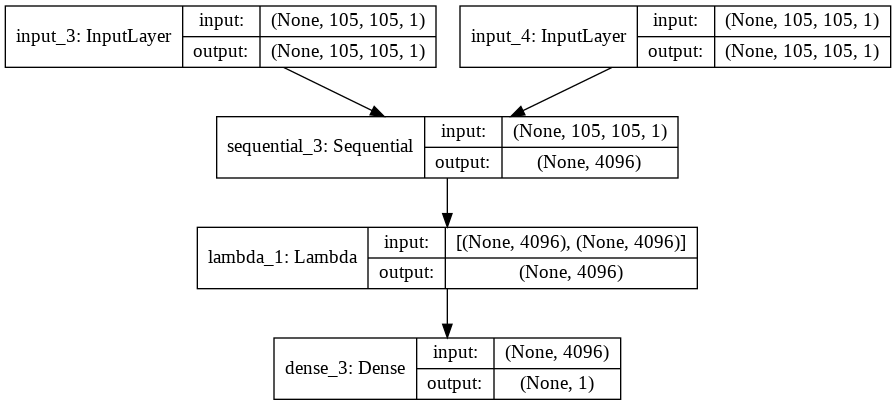

In [18]:
from IPython.display import Image
Image(retina=True, filename='model.png')

In [19]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

### Loading the train tensors

In [20]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (Xtrain, train_classes) = pickle.load(f)

print("Training alphabets: \n")
print(list(train_classes.values()))

Training alphabets: 

[[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [18, 18], [19, 19], [20, 20], [21, 21], [22, 22], [23, 23], [24, 24], [25, 25], [26, 26], [27, 27], [28, 28], [29, 29], [30, 30], [31, 31], [32, 32], [33, 33], [34, 34], [35, 35], [36, 36], [37, 37], [38, 38], [39, 39], [40, 40], [41, 41], [42, 42], [43, 43], [44, 44], [45, 45], [46, 46], [47, 47], [48, 48], [49, 49], [50, 50], [51, 51], [52, 52], [53, 53], [54, 54], [55, 55], [56, 56], [57, 57], [58, 58], [59, 59], [60, 60], [61, 61], [62, 62], [63, 63], [64, 64], [65, 65], [66, 66], [67, 67], [68, 68], [69, 69], [70, 70], [71, 71], [72, 72], [73, 73], [74, 74], [75, 75], [76, 76], [77, 77], [78, 78], [79, 79], [80, 80], [81, 81], [82, 82], [83, 83], [84, 84], [85, 85], [86, 86], [87, 87], [88, 88], [89, 89], [90, 90], [91, 91], [92, 92], [93, 93], [94, 94], [95, 95], [96, 96], [97, 97], [98, 98], [99, 99

In [21]:
with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (Xval, val_classes) = pickle.load(f)

print("Validation alphabets:", end="\n\n")
print(list(val_classes.values()))

Validation alphabets:

[[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11]]


In [22]:
def get_batch(batch_size,s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h, channels = X.shape

    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,3)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 3)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,3)
    
    return pairs, targets

In [23]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [65]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = train_classes
    else:
        X = Xval
        categories = val_classes
    n_classes, n_examples, w, h, channels = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
#         if N > high - low:
#             print("n, high, low", N, high, low)
#             raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(1,2),size=(N,),replace=False)

    else: # if no language specified just pick a bunch of random letters
#         print(categories)
#         print(n_classes)
#         print(N)
        categories = rng.choice(range(n_classes),size=(N,),replace=False)
    true_category = categories[0]
    print (n_examples)
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,3)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,3)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [25]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [26]:
# Hyper parameters
evaluate_every = 5 #200# interval for evaluating on one-shot tasks
batch_size = 10 #32
n_iter = 10 #20000 # No. of training iterations
N_way = 5 #20 # how many classes for testing one-shot tasks
n_val = 10 #250 # how many one-shot tasks to validate on
best = -1

# Hyper parameters
# evaluate_every = 200 # interval for evaluating on one-shot tasks
# batch_size = 32
# n_iter = 20000 # No. of training iterations
# N_way = 20 # how many classes for testing one-shot tasks
# n_val = 250 # how many one-shot tasks to validate on
# best = -1

In [27]:
model_path = 'data/weights/'

In [28]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    print (i % evaluate_every == 0)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(model, N_way, n_val, verbose=True)
        model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------
Instructions for updating:
Use tf.cast instead.
False
False
False
False
True

 ------------- 

Time for 5 iterations: 0.5759437481562296 mins
Train Loss: 4.071095943450928
Evaluating model on 10 random 5 way one-shot learning tasks ... 

{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
5
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
5
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
5
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [

In [29]:
X.shape

(110, 2, 105, 105, 3)

### Load model weights

In [30]:
model.load_weights(os.path.join(model_path, "weights.10.h5"))

### Testing

### Baseline model based on Nearest Neighbors using Euclidean distance (L2 distance)

In [35]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [37]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [38]:
ways = np.arange(1,2,2)
resume =  False
trials = 50

In [39]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 

{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
1
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
1
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
1
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
1
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [

{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
1
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
1
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
1
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
1
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19': [3, 3], 's21': [4, 4], 's11': [5, 5], 's1': [6, 6], 's37': [7, 7], 's25': [8, 8], 's40': [9, 9], 's15': [10, 10], 's48': [11, 11]}
12
1
2
{'s34': [0, 0], 's5': [1, 1], 's44': [2, 2], 's19'

{'s34': [0, 0], 's33': [1, 1], 's93': [2, 2], 's67': [3, 3], 's58': [4, 4], 's60': [5, 5], 's94': [6, 6], 's56': [7, 7], 's69': [8, 8], 's5': [9, 9], 's51': [10, 10], 's2': [11, 11], 's32': [12, 12], 's35': [13, 13], 's110': [14, 14], 's50': [15, 15], 's3': [16, 16], 's57': [17, 17], 's68': [18, 18], 's4': [19, 19], 's95': [20, 20], 's61': [21, 21], 's66': [22, 22], 's92': [23, 23], 's59': [24, 24], 's44': [25, 25], 's88': [26, 26], 's43': [27, 27], 's81': [28, 28], 's75': [29, 29], 's72': [30, 30], 's86': [31, 31], 's26': [32, 32], 's19': [33, 33], 's21': [34, 34], 's103': [35, 35], 's17': [36, 36], 's28': [37, 37], 's10': [38, 38], 's104': [39, 39], 's87': [40, 40], 's73': [41, 41], 's74': [42, 42], 's80': [43, 43], 's89': [44, 44], 's42': [45, 45], 's45': [46, 46], 's11': [47, 47], 's105': [48, 48], 's102': [49, 49], 's16': [50, 50], 's29': [51, 51], 's20': [52, 52], 's27': [53, 53], 's18': [54, 54], 's63': [55, 55], 's97': [56, 56], 's90': [57, 57], 's8': [58, 58], 's64': [59, 59],

{'s34': [0, 0], 's33': [1, 1], 's93': [2, 2], 's67': [3, 3], 's58': [4, 4], 's60': [5, 5], 's94': [6, 6], 's56': [7, 7], 's69': [8, 8], 's5': [9, 9], 's51': [10, 10], 's2': [11, 11], 's32': [12, 12], 's35': [13, 13], 's110': [14, 14], 's50': [15, 15], 's3': [16, 16], 's57': [17, 17], 's68': [18, 18], 's4': [19, 19], 's95': [20, 20], 's61': [21, 21], 's66': [22, 22], 's92': [23, 23], 's59': [24, 24], 's44': [25, 25], 's88': [26, 26], 's43': [27, 27], 's81': [28, 28], 's75': [29, 29], 's72': [30, 30], 's86': [31, 31], 's26': [32, 32], 's19': [33, 33], 's21': [34, 34], 's103': [35, 35], 's17': [36, 36], 's28': [37, 37], 's10': [38, 38], 's104': [39, 39], 's87': [40, 40], 's73': [41, 41], 's74': [42, 42], 's80': [43, 43], 's89': [44, 44], 's42': [45, 45], 's45': [46, 46], 's11': [47, 47], 's105': [48, 48], 's102': [49, 49], 's16': [50, 50], 's29': [51, 51], 's20': [52, 52], 's27': [53, 53], 's18': [54, 54], 's63': [55, 55], 's97': [56, 56], 's90': [57, 57], 's8': [58, 58], 's64': [59, 59],

{'s34': [0, 0], 's33': [1, 1], 's93': [2, 2], 's67': [3, 3], 's58': [4, 4], 's60': [5, 5], 's94': [6, 6], 's56': [7, 7], 's69': [8, 8], 's5': [9, 9], 's51': [10, 10], 's2': [11, 11], 's32': [12, 12], 's35': [13, 13], 's110': [14, 14], 's50': [15, 15], 's3': [16, 16], 's57': [17, 17], 's68': [18, 18], 's4': [19, 19], 's95': [20, 20], 's61': [21, 21], 's66': [22, 22], 's92': [23, 23], 's59': [24, 24], 's44': [25, 25], 's88': [26, 26], 's43': [27, 27], 's81': [28, 28], 's75': [29, 29], 's72': [30, 30], 's86': [31, 31], 's26': [32, 32], 's19': [33, 33], 's21': [34, 34], 's103': [35, 35], 's17': [36, 36], 's28': [37, 37], 's10': [38, 38], 's104': [39, 39], 's87': [40, 40], 's73': [41, 41], 's74': [42, 42], 's80': [43, 43], 's89': [44, 44], 's42': [45, 45], 's45': [46, 46], 's11': [47, 47], 's105': [48, 48], 's102': [49, 49], 's16': [50, 50], 's29': [51, 51], 's20': [52, 52], 's27': [53, 53], 's18': [54, 54], 's63': [55, 55], 's97': [56, 56], 's90': [57, 57], 's8': [58, 58], 's64': [59, 59],

{'s34': [0, 0], 's33': [1, 1], 's93': [2, 2], 's67': [3, 3], 's58': [4, 4], 's60': [5, 5], 's94': [6, 6], 's56': [7, 7], 's69': [8, 8], 's5': [9, 9], 's51': [10, 10], 's2': [11, 11], 's32': [12, 12], 's35': [13, 13], 's110': [14, 14], 's50': [15, 15], 's3': [16, 16], 's57': [17, 17], 's68': [18, 18], 's4': [19, 19], 's95': [20, 20], 's61': [21, 21], 's66': [22, 22], 's92': [23, 23], 's59': [24, 24], 's44': [25, 25], 's88': [26, 26], 's43': [27, 27], 's81': [28, 28], 's75': [29, 29], 's72': [30, 30], 's86': [31, 31], 's26': [32, 32], 's19': [33, 33], 's21': [34, 34], 's103': [35, 35], 's17': [36, 36], 's28': [37, 37], 's10': [38, 38], 's104': [39, 39], 's87': [40, 40], 's73': [41, 41], 's74': [42, 42], 's80': [43, 43], 's89': [44, 44], 's42': [45, 45], 's45': [46, 46], 's11': [47, 47], 's105': [48, 48], 's102': [49, 49], 's16': [50, 50], 's29': [51, 51], 's20': [52, 52], 's27': [53, 53], 's18': [54, 54], 's63': [55, 55], 's97': [56, 56], 's90': [57, 57], 's8': [58, 58], 's64': [59, 59],

{'s34': [0, 0], 's33': [1, 1], 's93': [2, 2], 's67': [3, 3], 's58': [4, 4], 's60': [5, 5], 's94': [6, 6], 's56': [7, 7], 's69': [8, 8], 's5': [9, 9], 's51': [10, 10], 's2': [11, 11], 's32': [12, 12], 's35': [13, 13], 's110': [14, 14], 's50': [15, 15], 's3': [16, 16], 's57': [17, 17], 's68': [18, 18], 's4': [19, 19], 's95': [20, 20], 's61': [21, 21], 's66': [22, 22], 's92': [23, 23], 's59': [24, 24], 's44': [25, 25], 's88': [26, 26], 's43': [27, 27], 's81': [28, 28], 's75': [29, 29], 's72': [30, 30], 's86': [31, 31], 's26': [32, 32], 's19': [33, 33], 's21': [34, 34], 's103': [35, 35], 's17': [36, 36], 's28': [37, 37], 's10': [38, 38], 's104': [39, 39], 's87': [40, 40], 's73': [41, 41], 's74': [42, 42], 's80': [43, 43], 's89': [44, 44], 's42': [45, 45], 's45': [46, 46], 's11': [47, 47], 's105': [48, 48], 's102': [49, 49], 's16': [50, 50], 's29': [51, 51], 's20': [52, 52], 's27': [53, 53], 's18': [54, 54], 's63': [55, 55], 's97': [56, 56], 's90': [57, 57], 's8': [58, 58], 's64': [59, 59],

{'s34': [0, 0], 's33': [1, 1], 's93': [2, 2], 's67': [3, 3], 's58': [4, 4], 's60': [5, 5], 's94': [6, 6], 's56': [7, 7], 's69': [8, 8], 's5': [9, 9], 's51': [10, 10], 's2': [11, 11], 's32': [12, 12], 's35': [13, 13], 's110': [14, 14], 's50': [15, 15], 's3': [16, 16], 's57': [17, 17], 's68': [18, 18], 's4': [19, 19], 's95': [20, 20], 's61': [21, 21], 's66': [22, 22], 's92': [23, 23], 's59': [24, 24], 's44': [25, 25], 's88': [26, 26], 's43': [27, 27], 's81': [28, 28], 's75': [29, 29], 's72': [30, 30], 's86': [31, 31], 's26': [32, 32], 's19': [33, 33], 's21': [34, 34], 's103': [35, 35], 's17': [36, 36], 's28': [37, 37], 's10': [38, 38], 's104': [39, 39], 's87': [40, 40], 's73': [41, 41], 's74': [42, 42], 's80': [43, 43], 's89': [44, 44], 's42': [45, 45], 's45': [46, 46], 's11': [47, 47], 's105': [48, 48], 's102': [49, 49], 's16': [50, 50], 's29': [51, 51], 's20': [52, 52], 's27': [53, 53], 's18': [54, 54], 's63': [55, 55], 's97': [56, 56], 's90': [57, 57], 's8': [58, 58], 's64': [59, 59],

{'s34': [0, 0], 's33': [1, 1], 's93': [2, 2], 's67': [3, 3], 's58': [4, 4], 's60': [5, 5], 's94': [6, 6], 's56': [7, 7], 's69': [8, 8], 's5': [9, 9], 's51': [10, 10], 's2': [11, 11], 's32': [12, 12], 's35': [13, 13], 's110': [14, 14], 's50': [15, 15], 's3': [16, 16], 's57': [17, 17], 's68': [18, 18], 's4': [19, 19], 's95': [20, 20], 's61': [21, 21], 's66': [22, 22], 's92': [23, 23], 's59': [24, 24], 's44': [25, 25], 's88': [26, 26], 's43': [27, 27], 's81': [28, 28], 's75': [29, 29], 's72': [30, 30], 's86': [31, 31], 's26': [32, 32], 's19': [33, 33], 's21': [34, 34], 's103': [35, 35], 's17': [36, 36], 's28': [37, 37], 's10': [38, 38], 's104': [39, 39], 's87': [40, 40], 's73': [41, 41], 's74': [42, 42], 's80': [43, 43], 's89': [44, 44], 's42': [45, 45], 's45': [46, 46], 's11': [47, 47], 's105': [48, 48], 's102': [49, 49], 's16': [50, 50], 's29': [51, 51], 's20': [52, 52], 's27': [53, 53], 's18': [54, 54], 's63': [55, 55], 's97': [56, 56], 's90': [57, 57], 's8': [58, 58], 's64': [59, 59],

{'s34': [0, 0], 's33': [1, 1], 's93': [2, 2], 's67': [3, 3], 's58': [4, 4], 's60': [5, 5], 's94': [6, 6], 's56': [7, 7], 's69': [8, 8], 's5': [9, 9], 's51': [10, 10], 's2': [11, 11], 's32': [12, 12], 's35': [13, 13], 's110': [14, 14], 's50': [15, 15], 's3': [16, 16], 's57': [17, 17], 's68': [18, 18], 's4': [19, 19], 's95': [20, 20], 's61': [21, 21], 's66': [22, 22], 's92': [23, 23], 's59': [24, 24], 's44': [25, 25], 's88': [26, 26], 's43': [27, 27], 's81': [28, 28], 's75': [29, 29], 's72': [30, 30], 's86': [31, 31], 's26': [32, 32], 's19': [33, 33], 's21': [34, 34], 's103': [35, 35], 's17': [36, 36], 's28': [37, 37], 's10': [38, 38], 's104': [39, 39], 's87': [40, 40], 's73': [41, 41], 's74': [42, 42], 's80': [43, 43], 's89': [44, 44], 's42': [45, 45], 's45': [46, 46], 's11': [47, 47], 's105': [48, 48], 's102': [49, 49], 's16': [50, 50], 's29': [51, 51], 's20': [52, 52], 's27': [53, 53], 's18': [54, 54], 's63': [55, 55], 's97': [56, 56], 's90': [57, 57], 's8': [58, 58], 's64': [59, 59],

{'s34': [0, 0], 's33': [1, 1], 's93': [2, 2], 's67': [3, 3], 's58': [4, 4], 's60': [5, 5], 's94': [6, 6], 's56': [7, 7], 's69': [8, 8], 's5': [9, 9], 's51': [10, 10], 's2': [11, 11], 's32': [12, 12], 's35': [13, 13], 's110': [14, 14], 's50': [15, 15], 's3': [16, 16], 's57': [17, 17], 's68': [18, 18], 's4': [19, 19], 's95': [20, 20], 's61': [21, 21], 's66': [22, 22], 's92': [23, 23], 's59': [24, 24], 's44': [25, 25], 's88': [26, 26], 's43': [27, 27], 's81': [28, 28], 's75': [29, 29], 's72': [30, 30], 's86': [31, 31], 's26': [32, 32], 's19': [33, 33], 's21': [34, 34], 's103': [35, 35], 's17': [36, 36], 's28': [37, 37], 's10': [38, 38], 's104': [39, 39], 's87': [40, 40], 's73': [41, 41], 's74': [42, 42], 's80': [43, 43], 's89': [44, 44], 's42': [45, 45], 's45': [46, 46], 's11': [47, 47], 's105': [48, 48], 's102': [49, 49], 's16': [50, 50], 's29': [51, 51], 's20': [52, 52], 's27': [53, 53], 's18': [54, 54], 's63': [55, 55], 's97': [56, 56], 's90': [57, 57], 's8': [58, 58], 's64': [59, 59],

### Save the accuracies on disk

In [40]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

### Load the accuracies from disk

In [41]:
# with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
#     (val_accs, train_accs, nn_accs) = pickle.load(f)

### Below two functions are used for visualizing test image and support set

In [76]:
# def concat_images(X):
#     """Concatenates a bunch of images into a big matrix for plotting purposes."""
#     nc, h , w, _ = X.shape
# #     X = X.reshape(nc, h, w)
#     X = X.reshape(h, w, 3)
#     n = np.ceil(np.sqrt(nc)).astype("int8")
#     img = np.zeros((n*w,n*h))
#     x = 0
#     y = 0
#     for example in range(nc):
#         img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
#         y += 1
#         if y >= n:
#             y = 0
#             x += 1
#     return img

In [68]:
# def plot_oneshot_task(pairs):
#     fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
# #     ax1.matshow(pairs[0][0].reshape(480,480), cmap='gray')
#     ax1.matshow(pairs[0][0].reshape(105,105,3))
#     img = concat_images(pairs[1])
#     ax1.get_yaxis().set_visible(False)
#     ax1.get_xaxis().set_visible(False)
#     ax2.matshow(img,cmap='gray')
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

In [50]:
# # Example of concat image visualization
# pairs, targets = make_oneshot_task(16,"train","s1")
# plot_oneshot_task(pairs)

### Resuts

2


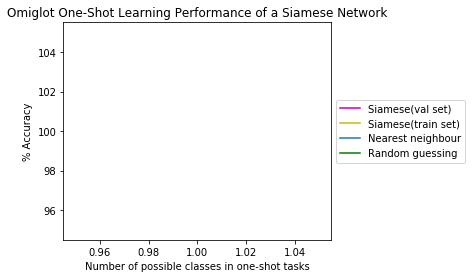

ValueError: could not broadcast input array from shape (105,3) into shape (105,105)

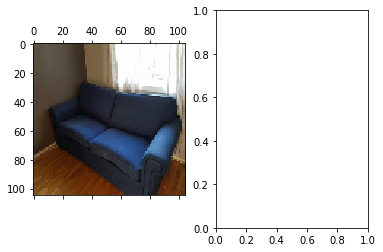

In [77]:
# fig,ax = plt.subplots(1)
# ax.plot(ways, val_accs, "m", label="Siamese(val set)")
# ax.plot(ways, train_accs, "y", label="Siamese(train set)")
# plt.plot(ways, nn_accs, label="Nearest neighbour")

# ax.plot(ways, 100.0/ways, "g", label="Random guessing")
# plt.xlabel("Number of possible classes in one-shot tasks")
# plt.ylabel("% Accuracy")
# plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# inputs,targets = make_oneshot_task(1, "val", 's1')
# plt.show()

# plot_oneshot_task(inputs)